In [5]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:00a 0:00:01


In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
from faker import Faker
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [9]:
def load_datasets(directory):
    """Load and combine all YouTube CSV files."""
    file_names = [
        'Youtube01-Psy.csv',
        'Youtube02-KatyPerry.csv',
        'Youtube03-LMFAO.csv',
        'Youtube04-Eminem.csv',
        'Youtube05-Shakira.csv'
    ]
    
    all_data = []
    for file in file_names:
        file_path = os.path.join(directory, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)

In [15]:
def analysis_of_dataset(df):
    """Perform basic dataset analysis including class balance."""
    # First, let's see what columns we actually have
    print("Column names in the dataset:")
    print(df.columns.tolist())
    
    # Display first few rows to understand the structure
    print("\nFirst few rows of the dataset:")
    print(df.head())
    
    # Overall dataset size
    print(f"\nTotal number of rows: {len(df)}")
    print(f"Number of unique authors: {df['AUTHOR'].nunique()}")
    
    # Text length statistics
    df['comment_length'] = df['CONTENT'].str.len()
    print("\nComment Length Statistics:")
    print(df['comment_length'].describe().round(2))
    
    # Missing values check
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Dataset balance analysis
    print("\nClass Balance Analysis:")
    class_distribution = df['CLASS'].value_counts(normalize=True) * 100
    print("\nClass Distribution (%):")
    for class_label, percentage in class_distribution.items():
        label = "Spam" if class_label == 1 else "Not Spam"
        print(f"{label}: {percentage:.2f}%")
    
    # Raw counts
    class_counts = df['CLASS'].value_counts()
    print("\nRaw Counts:")
    for class_label, count in class_counts.items():
        label = "Spam" if class_label == 1 else "Not Spam"
        print(f"{label}: {count}")
    
    # Distribution by video/source if available
    if 'SOURCE' in df.columns:
        print("\nClass Distribution by Source:")
        print(pd.crosstab(df['SOURCE'], df['CLASS'], normalize='index') * 100)
        
    # Visualize class distribution
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        
        # Bar plot of class distribution
        plt.subplot(1, 2, 1)
        class_counts.plot(kind='bar')
        plt.title('Class Distribution')
        plt.xlabel('Class (0: Not Spam, 1: Spam)')
        plt.ylabel('Count')
        
        # Pie chart of class distribution
        plt.subplot(1, 2, 2)
        plt.pie(class_counts, labels=['Not Spam', 'Spam'], autopct='%1.1f%%')
        plt.title('Class Distribution (%)')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("\nNote: Matplotlib is not installed. Skipping visualizations.")

In [17]:
def model_1(df):
    df = df[["CONTENT","CLASS"]].copy()
    df["CLASS"] = df["CLASS"].map({0: "Not Spam", 1: "Spam Comment"})
    
    x = np.array(df["CONTENT"])
    y = np.array(df["CLASS"])
    
    cv = CountVectorizer()
    x = cv.fit_transform(x)
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)
    
    model = BernoulliNB()
    model.fit(xtrain, ytrain)
    
    # Get predictions
    y_pred = model.predict(xtest)
    
    # Evaluate model
    evaluate_model(ytest, y_pred)
    
    return cv, model

In [19]:
def check_spam(text, cv, model):
    data = cv.transform([text]).toarray() # Transform text and predict
    prediction = model.predict(data)
    print(f"Comment: {text}")
    print(f"Prediction: {prediction[0]}\n")

In [21]:
def evaluate_model(y_test, y_pred):
    """
    Evaluate model performance using multiple metrics including False Positive Rate
    Args:
        y_test: True labels
        y_pred: Predicted labels
    """
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label="Spam Comment")
    recall = recall_score(y_test, y_pred, pos_label="Spam Comment")
    f1 = f1_score(y_test, y_pred, pos_label="Spam Comment")
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate False Positive Rate
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)  # False Positive Rate
    
    # Print results
    print("Model Performance Metrics:")
    print("-" * 30)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")  # Added FPR
    
    # Additional rate calculations
    tpr = recall  # True Positive Rate (same as recall)
    tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
    fnr = fn / (fn + tp)  # False Negative Rate
    
    print(f"\nDetailed Rates:")
    print(f"True Positive Rate (Sensitivity/Recall): {tpr:.4f}")
    print(f"True Negative Rate (Specificity): {tnr:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")
    
    print("\nConfusion Matrix:")
    print("               Predicted Not Spam  Predicted Spam")
    print(f"Actual Not Spam     {conf_matrix[0][0]}              {conf_matrix[0][1]}")
    print(f"Actual Spam         {conf_matrix[1][0]}              {conf_matrix[1][1]}")

In [43]:
directory = r"C:\Users\vasud\projects\CSCE_704_final_project\dataset"
print("Loading datasets...")
df = load_datasets(directory)

Loading datasets...


Column names in the dataset:
['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS']

First few rows of the dataset:
                                    COMMENT_ID            AUTHOR  \
0  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU         Julius NM   
1  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A       adam riyati   
2  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  Evgeny Murashkin   
3          z13jhp0bxqncu512g22wvzkasxmvvzjaz04   ElNino Melendez   
4          z13fwbwp1oujthgqj04chlngpvzmtt3r3dw            GsMega   

                  DATE                                            CONTENT  \
0  2013-11-07T06:20:48  Huh, anyway check out this you[tube] channel: ...   
1  2013-11-07T12:37:15  Hey guys check out my new channel and our firs...   
2  2013-11-08T17:34:21             just for test I have to say murdev.com   
3  2013-11-09T08:28:43   me shaking my sexy ass on my channel enjoy ^_^ ﻿   
4  2013-11-10T16:05:38            watch?v=vtaRGgvGtWQ   Check this out .﻿   

   CLASS  
0  

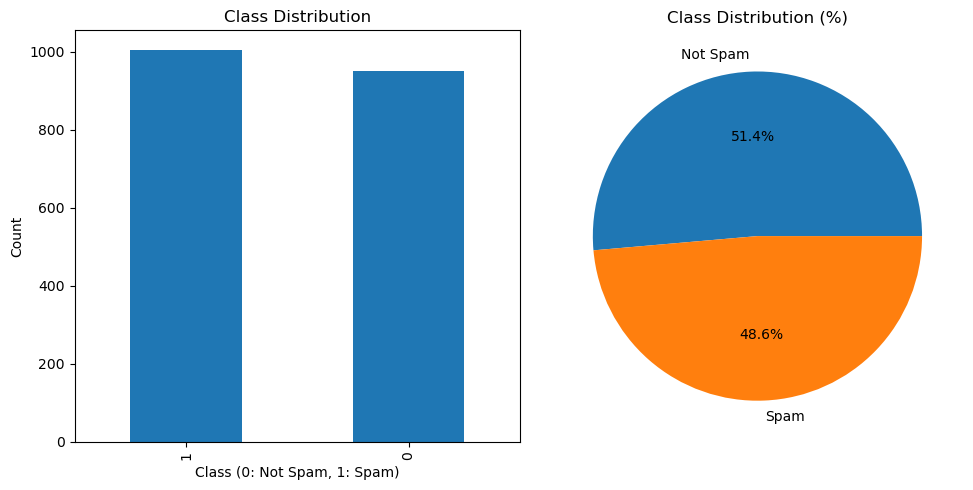

In [51]:
analysis_of_dataset(df)

In [44]:
cv, model = model_1(df)

Model Performance Metrics:
------------------------------
Accuracy: 0.8852
Precision: 0.9831
Recall: 0.8056
F1 Score: 0.8855
False Positive Rate: 0.0170

Detailed Rates:
True Positive Rate (Sensitivity/Recall): 0.8056
True Negative Rate (Specificity): 0.9830
False Positive Rate: 0.0170
False Negative Rate: 0.1944

Confusion Matrix:
               Predicted Not Spam  Predicted Spam
Actual Not Spam     173              3
Actual Spam         42              174


In [23]:
def generate_dataset_csv(n_samples=2000, output_file="synthetic_youtube_comments.csv"):
    """
    Generate a synthetic YouTube comments dataset and save it to CSV.
    
    Args:
        n_samples (int): Number of comments to generate (default: 2000)
        output_file (str): Name of the output CSV file
        
    Returns:
        pd.DataFrame: The generated dataset
    """
    fake = Faker()
    
    # Set random seed for reproducibility
    random.seed(42)
    Faker.seed(42)
    np.random.seed(42)
    
    # Lists for variety in comment generation
    video_topics = ['Music Video', 'Tutorial', 'Vlog', 'Gaming', 'Review', 'Comedy']
    
    def create_benign_comment():
        templates = [
            f"Love this {random.choice(video_topics).lower()}! Been following since {random.randint(2015, 2023)}",
            f"Amazing content as always! Watched it {random.randint(2, 5)} times already",
            f"The editing at {random.randint(1, 10)}:{random.randint(10, 59)} was incredible",
            "This really helped me understand the topic better!",
            "Great points made in this video, especially about the main topic",
            f"Subscribed! Can't wait for the next {random.choice(video_topics).lower()}",
            "The background music choice was perfect",
            "Very well explained and presented",
            f"Been waiting for this type of {random.choice(video_topics).lower()}!",
            "The quality keeps getting better and better"
        ]
        return random.choice(templates)
    
    def create_spam_pattern():
        templates = [
            f"Hey, is this {fake.name()} from {fake.city()}? I think we went to {fake.company()} together",
            f"Found some info about {fake.name()} at {fake.street_address()}, {fake.city()}",
            f"Looking for {fake.name()} - used to work at {fake.company()} in {fake.state()}",
            f"Anyone know if {fake.name()} still lives in {fake.city()}?",
            f"Pretty sure {fake.name()} from {fake.city()} is behind this channel",
            f"Found {fake.name()}'s personal info and {fake.company()} profile",
            f"This must be {fake.name()}'s new channel - moved from {fake.city()} right?",
            f"Remember {fake.name()} from {fake.company()}? They live at {fake.street_address()} now",
            f"Got details about {fake.name()} - worked at {fake.company()} in {fake.state()}",
            f"Is the owner {fake.name()}? The one from {fake.city()}, {fake.state()}?"
        ]
        return random.choice(templates)
    
    data = []
    # Generate balanced dataset
    for i in range(n_samples):
        is_spam = i < n_samples/2  # First half spam, second half non-spam
        
        timestamp = fake.date_time_between(start_date='-1y', end_date='now')
        
        entry = {
            'COMMENT_ID': f'COM_{i:05d}',
            'AUTHOR': fake.user_name(),
            'DATE': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'CONTENT': create_spam_pattern() if is_spam else create_benign_comment(),
            'CLASS': 1 if is_spam else 0,
            'LIKES': np.random.randint(0, 100),
            'REPLIES': np.random.randint(0, 10)
        }
        data.append(entry)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add metadata at the top of the file
    metadata = [
        "# Synthetic YouTube Comments Dataset",
        "# Generated for academic purposes",
        "# Dataset characteristics:",
        f"# - Total samples: {n_samples}",
        f"# - Spam samples: {n_samples//2}",
        f"# - Non-spam samples: {n_samples//2}",
        f"# - Generation date: {pd.Timestamp.now().strftime('%Y-%m-%d')}",
        "# - All personal information is synthetic and generated using Faker library",
        "#"
    ]
    
    # Save to CSV with metadata
    with open(output_file, 'w', encoding='utf-8') as f:
        for line in metadata:
            f.write(line + '\n')
        
    # Append the DataFrame to the same file
    df.to_csv(output_file, mode='a', index=False)
    
    print(f"Dataset successfully generated and saved to {output_file}")
    print(f"Total number of samples: {n_samples}")
    print(f"Number of spam comments: {sum(df['CLASS'] == 1)}")
    print(f"Number of non-spam comments: {sum(df['CLASS'] == 0)}")
    
    return df

# Example usage:
# df = generate_dataset_csv(n_samples=2000, output_file="synthetic_youtube_comments.csv")

In [53]:
# Function to test the comments against your trained model
def test_synthetic_comments(cv, model, n_samples=10):
    """
    Generate and test synthetic comments against trained model
    """
    test_data = generate_synthetic_comments(n_samples)
    
    print("Testing Synthetic Comments:")
    print("-" * 50)
    
    for _, row in test_data.iterrows():
        comment = row['CONTENT']
        actual_class = "Spam" if row['CLASS'] == 1 else "Not Spam"
        
        # Transform and predict
        data = cv.transform([comment]).toarray()
        predicted_class = model.predict(data)[0]
        
        print(f"\nComment: {comment}")
        print(f"Actual Class: {actual_class}")
        print(f"Predicted Class: {predicted_class}")
        print("-" * 50)
        
    return test_data

In [25]:
def evaluate_synthetic_performance(cv, model, n_samples=1000):
    """
    Generate synthetic data and evaluate model performance on it.
    
    Args:
        cv: Trained CountVectorizer
        model: Trained model
        n_samples: Number of synthetic samples to generate
    """
    # Generate synthetic dataset
    print(f"Generating {n_samples} synthetic comments...")
    synthetic_data = generate_synthetic_comments(n_samples)
    
    # Transform and predict
    X_synthetic = cv.transform(synthetic_data['CONTENT'])
    y_true = synthetic_data['CLASS'].map({0: "Not Spam", 1: "Spam Comment"})
    y_pred = model.predict(X_synthetic)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label="Spam Comment")
    recall = recall_score(y_true, y_pred, pos_label="Spam Comment")
    f1 = f1_score(y_true, y_pred, pos_label="Spam Comment")
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Calculate rates
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)  # False Positive Rate
    tpr = recall  # True Positive Rate (same as recall)
    tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # Print results
    print("\nModel Performance on Synthetic Data:")
    print("-" * 40)
    print(f"Total samples tested: {n_samples}")
    print(f"\nPrimary Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")
    
    print(f"\nDetailed Rates:")
    print(f"True Positive Rate (Sensitivity/Recall): {tpr:.4f}")
    print(f"True Negative Rate (Specificity): {tnr:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")
    
    print("\nConfusion Matrix:")
    print("               Predicted Not Spam  Predicted Spam")
    print(f"Actual Not Spam     {conf_matrix[0][0]}              {conf_matrix[0][1]}")
    print(f"Actual Spam         {conf_matrix[1][0]}              {conf_matrix[1][1]}")
    
    # Sample misclassifications
    print("\nSample Misclassifications:")
    print("-" * 40)
    
    # False Positives (Non-spam classified as spam)
    fp_mask = (y_true == "Not Spam") & (y_pred == "Spam Comment")
    fp_samples = synthetic_data[fp_mask]['CONTENT'].head(3)
    if len(fp_samples) > 0:
        print("\nFalse Positives (Normal comments mistaken as spam):")
        for comment in fp_samples:
            print(f"- {comment}")
            
    # False Negatives (Spam classified as non-spam)
    fn_mask = (y_true == "Spam Comment") & (y_pred == "Not Spam")
    fn_samples = synthetic_data[fn_mask]['CONTENT'].head(3)
    if len(fn_samples) > 0:
        print("\nFalse Negatives (Spam comments missed by the model):")
        for comment in fn_samples:
            print(f"- {comment}")
            
    return synthetic_data, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'confusion_matrix': conf_matrix
    }

In [55]:
# Test model on 1000 synthetic comments
synthetic_data, metrics = evaluate_synthetic_performance(cv, model, n_samples=1000)

Generating 1000 synthetic comments...

Model Performance on Synthetic Data:
----------------------------------------
Total samples tested: 1000

Primary Metrics:
Accuracy: 0.4950
Precision: 1.0000
Recall: 0.0020
F1 Score: 0.0039
False Positive Rate: 0.0000

Detailed Rates:
True Positive Rate (Sensitivity/Recall): 0.0020
True Negative Rate (Specificity): 1.0000
False Positive Rate: 0.0000
False Negative Rate: 0.9980

Confusion Matrix:
               Predicted Not Spam  Predicted Spam
Actual Not Spam     494              0
Actual Spam         505              1

Sample Misclassifications:
----------------------------------------

False Negatives (Spam comments missed by the model):
- Looking for Priscilla Alvarez - used to live in West Zacharyport
- Pretty sure Derrick Brewer lives at 2956 James Bridge right?
- Looking for Brett Jones - used to live in Isabellamouth


In [56]:
# Generate 2000 samples (1000 spam, 1000 non-spam)
dataset = generate_dataset_csv(
    n_samples=2000, 
    output_file="synthetic_youtube_comments.csv"
)

Dataset successfully generated and saved to synthetic_youtube_comments.csv
Total number of samples: 2000
Number of spam comments: 1000
Number of non-spam comments: 1000


In [67]:
def train_tfidf_model(synthetic_data, original_data=None):
    """
    Train a spam detection model using TF-IDF vectorization.
    Can use both synthetic and original data for training.
    
    Args:
        synthetic_data: DataFrame containing synthetic comments
        original_data: Optional DataFrame containing original training data
    """
    # Combine datasets if original data is provided
    if original_data is not None:
        X = np.concatenate([original_data['CONTENT'], synthetic_data['CONTENT']])
        y = np.concatenate([
            original_data['CLASS'].map({0: "Not Spam", 1: "Spam Comment"}),
            synthetic_data['CLASS'].map({0: "Not Spam", 1: "Spam Comment"})
        ])
    else:
        X = synthetic_data['CONTENT']
        y = synthetic_data['CLASS'].map({0: "Not Spam", 1: "Spam Comment"})
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Initialize TF-IDF vectorizer
    tfidf = TfidfVectorizer(
        max_features=5000,
        min_df=2,              # Minimum document frequency
        max_df=0.8,            # Maximum document frequency
        ngram_range=(1, 2),    # Use both unigrams and bigrams
        stop_words='english'
    )
    
    # Transform the text data
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    # Train the model
    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate and print metrics
    print("Model Performance with TF-IDF:")
    print("-" * 40)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print most important features for spam detection
    feature_importance = model.feature_log_prob_[1] - model.feature_log_prob_[0]
    feature_names = np.array(tfidf.get_feature_names_out())
    
    top_spam_features = feature_names[np.argsort(feature_importance)[-10:]]
    print("\nTop 10 features indicating spam:")
    for feature in reversed(top_spam_features):
        print(f"- {feature}")
    
    # Function to analyze a specific comment
    def analyze_comment(comment):
        comment_tfidf = tfidf.transform([comment])
        prediction = model.predict(comment_tfidf)[0]
        proba = model.predict_proba(comment_tfidf)[0]
        return prediction, proba

    return tfidf, model, analyze_comment

def test_tfidf_model(tfidf, model, test_comments):
    """
    Test the TF-IDF model on specific comments and show detailed analysis.
    """
    print("\nTesting specific comments:")
    print("-" * 40)
    
    for comment in test_comments:
        # Transform and predict
        comment_tfidf = tfidf.transform([comment])
        prediction = model.predict(comment_tfidf)[0]
        probabilities = model.predict_proba(comment_tfidf)[0]
        
        print(f"\nComment: {comment}")
        print(f"Prediction: {prediction}")
        print(f"Confidence: {max(probabilities):.2%}")
        print(f"Probability distribution: Not Spam: {probabilities[0]:.2%}, Spam: {probabilities[1]:.2%}")

In [68]:
# Train the model
tfidf, model, analyze_comment = train_tfidf_model(synthetic_data)

Model Performance with TF-IDF:
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

    Not Spam       1.00      1.00      1.00       201
Spam Comment       1.00      1.00      1.00       199

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Top 10 features indicating spam:
- channel
- info
- new
- know
- lives
- pretty
- pretty sure
- sure
- new channel
- moved


In [69]:
    # Test some example comments
    test_comments = [
        "Great video! Really enjoyed the content!",
        "Found John Smith's address in New York, anyone know if that's correct?",
        "Is this Jane Doe from Seattle? I think we went to school together",
        "The editing in this video is amazing!",
        "Looking for contact info of the channel owner"
    ]
    
    test_tfidf_model(tfidf, model, test_comments)


Testing specific comments:
----------------------------------------

Comment: Great video! Really enjoyed the content!
Prediction: Not Spam
Confidence: 99.89%
Probability distribution: Not Spam: 99.89%, Spam: 0.11%

Comment: Found John Smith's address in New York, anyone know if that's correct?
Prediction: Spam Comment
Confidence: 98.77%
Probability distribution: Not Spam: 1.23%, Spam: 98.77%

Comment: Is this Jane Doe from Seattle? I think we went to school together
Prediction: Spam Comment
Confidence: 99.38%
Probability distribution: Not Spam: 0.62%, Spam: 99.38%

Comment: The editing in this video is amazing!
Prediction: Not Spam
Confidence: 99.77%
Probability distribution: Not Spam: 99.77%, Spam: 0.23%

Comment: Looking for contact info of the channel owner
Prediction: Spam Comment
Confidence: 99.84%
Probability distribution: Not Spam: 0.16%, Spam: 99.84%
